In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import yfinance as yf
from scipy.signal import argrelextrema
# from collections import deque
# from matplotlib.lines import Line2D
import pandas_ta as ta
import ccxt
from datetime import datetime, timedelta
# import plotly.graph_objects as go
# import inspect 
import os


pd.set_option('display.max_rows', None)



In [2]:
exchange = ccxt.binance()
exchange.load_markets()

symbols = exchange.symbols

In [3]:

# ticker = 'BTC-USDT'
# timeframe ='4h'
# use bars[-1] to avoid false signal espeacially in current candle
# because ccxt gives the ongoing candle before they close
# do bars[-3] to get less trades; but better quality
def ccxt_data(symbol='BTC/USDT', timeframe ='1d', limit=100):
    global data
    # global fullname

    m_symbol = symbol.replace("/","_")
    outname = m_symbol+'_'+timeframe+'_'+f'{limit}'+'.csv'
    outdir=os.getcwd()+f'/data/{timeframe}'
    fullname = os.path.join(outdir, outname)    

    if not os.path.exists(outdir):
        os.mkdir(outdir)

    if not (os.path.exists(fullname)):

        bars = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
        data = pd.DataFrame(bars[:-3], columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
        data['Time'] = pd.to_datetime(data['Time'], unit='ms')
        data.set_index('Time', inplace=True)

        data.to_csv(fullname) 
    
    else:
        data = pd.read_csv(fullname)
        


    return data

In [4]:
# # ticker = 'BTC-USDT'
# # timeframe ='4h'
# # use bars[-1] to avoid false signal espeacially in current candle
# # because ccxt gives the ongoing candle before they close
# # do bars[-3] to get less trades; but better quality
# def ccxt_data(symbol='BTC/USDT', timeframe ='1d', limit=100):
#     global data

#     # if csv file not exist 
#     # os.path.exists(path_to_file)
#     # os.path.exists(os.getcwd()+f'/data/{timeframe}/{outname}')

#     bars = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
#     data = pd.DataFrame(bars[:-3], columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
#     data['Time'] = pd.to_datetime(data['Time'], unit='ms')
#     data.set_index('Time', inplace=True)
    
#     m_symbol = symbol.replace("/","_")
#     outname = m_symbol+'_'+timeframe+'_'+f'{limit}'
    
#     outdir=os.getcwd()+f'/data/{timeframe}'

#     # outdir = f'./dir/data/{timeframe}'
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)

#     fullname = os.path.join(outdir, outname)    

#     data.to_csv(fullname) 

#     # else
#     # data = read csv 
#     #   

#     return data



In [5]:
# def savetocsv(symbol, timeframe, limit):
#     # outname = 'name.csv'
#     m_symbol = symbol.replace("/","_")
#     outname = m_symbol+'_'+timeframe+'_'+f'{limit}'
    
#     outdir=os.getcwd()+f'/data/{timeframe}'

#     # outdir = f'./dir/data/{timeframe}'
#     if not os.path.exists(outdir):
#         os.mkdir(outdir)

#     fullname = os.path.join(outdir, outname)    

#     data.to_csv(fullname)

In [6]:
# data=ccxt_data()

def calc():
    
    # data=ccxt_data()
    # calc indicator
    data['ta_rsi'] = ta.rsi(data['Close'], length = 14)

    # calc peaks and troughs of close price and the indicator(s)
    coin_peak = argrelextrema(data['Close'].values, np.greater, order=5)[0]
    # print(coin_peak)
    coin_peaks_df = data.iloc[coin_peak]['Close']
    # print(coin_peaks_df)

    ta_peak = argrelextrema(data['ta_rsi'].values, np.greater, order=5)[0]
    ta_peaks_df = data.iloc[ta_peak]['ta_rsi']
    # print(ta_peaks_df)

    coin_trough = argrelextrema(data['Close'].values, np.less, order=5)[0]
    coin_trough_df = data.iloc[coin_trough]['Close']

    ta_trough = argrelextrema(data['ta_rsi'].values, np.less, order=5)[0]
    ta_trough_df = data.iloc[ta_trough]['ta_rsi']

    global peaks_df
    global troughs_df

    peaks = [coin_peaks_df, ta_peaks_df]
    peaks_df = pd.concat(peaks, axis=1)
    peaks_df = peaks_df[(peaks_df.Close.notna()) & (peaks_df.ta_rsi.notna())]

    troughs = [coin_trough_df, ta_trough_df]
    troughs_df = pd.concat(troughs, axis=1)
    troughs_df = troughs_df[(troughs_df.Close.notna()) & (troughs_df.ta_rsi.notna())]

    # print(peaks)

    return peaks_df, troughs_df


# def trough_diff(n=1):

#     diff = troughs_df.diff(n)
#     sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
#     return sig

# def peak_diff(n=1):

#     diff = peaks_df.diff(n)
#     sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
#     return sig
# calc()

In [7]:
# calc()
# peaks_df.Close.iloc[-1]
# i think the problem is in the index
# it should be regular 1 2 3 4 5 6 ....


In [8]:

# peaks_df, troughs_df = calc()

def signal_dates(n=9):
    # peaks_df, troughs_df = calc()

    dates_of_peaks = []
    for i in range(n):
        if i == 0:
            diff = peaks_df.diff(1)
            sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
            dates_of_peaks.append(sig.index.values)
            continue
        diff = peaks_df.diff(i)
        sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
        dates_of_peaks.append(sig.index.values)

    dates_of_troughs = []
    for i in range(n):
        if i == 0:
            diff = troughs_df.diff(1)
            sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
            dates_of_troughs.append(sig.index.values)
            continue
        diff = troughs_df.diff(i)
        sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
        dates_of_troughs.append(sig.index.values)

    global sell
    sell = []
    for list in dates_of_peaks:
        for i in list:
            if i not in sell:
                # i = i + np.timedelta64(4, 'h') # adj sell date
                sell.append(i)

    global buy
    buy = []
    for list in dates_of_troughs:
        for i in list:
            if i not in buy:
                # i = i + np.timedelta64(4, 'h')
                buy.append(i)
                

    sell.sort()
    buy.sort()
    # print(dates_of_peaks)
    # problem : buy ans sell should be list of datetime***********************


    return sell, buy

# signal_dates()


In [9]:
# def bsm_allah(ticker='BTC/USDT',timeframe='4h',limit=100):
    
#     ccxt_data(ticker,timeframe,limit)
#     calc()
#     signal_dates()
#     # sell, buy = signal_dates()

#     # ticker = str(inspect.signature(bsm_allah).parameters['ticker'])
#     # timeframe = str(inspect.signature(bsm_allah).parameters['timeframe'])

#     print(f'last buy signal was {buy[-1]}')
#     # global buy_list_dates 
#     # buy_list_dates = []
#     # buy_list_dates.insert(len(buy_list_dates),buy[-1])

#     print(f'last sell signal was {sell[-1]}')
#     # global sell_list_dates 
#     # sell_list_dates = []
#     # sell_list_dates.insert(len(sell_list_dates),sell[-1])
     
# bsm_allah('EOS/BTC','1d',150)

In [10]:
# import pairs

t = 'BUSD'
pairs = []

unwanted = ["UST","ETH/","BKRW","VAI","RUB","NGN","DAI","BIDR","BEAR", "BULL", "PAX", "TUSD", "UMA", "USDC", "USDP", "BUSD/", "EUR", "USDT", "GBP", "TRY", "AUD","BRL", "BVND"]

for s in symbols:
    if (t in s):
        pairs.append(s)

pairs=[n for n in pairs if all(m not in n for m in unwanted)]


test_pairs = ["GLMR/BUSD", "AAVE/ETH"]

In [11]:
from IPython.core.display import display, HTML


# always put the list out of the loop or everthing will be wiped out each turn
rows = []
timeframe = '4h'
limit = 111

for symbol in pairs:

    
    ccxt_data(symbol,timeframe,limit)
    # savetocsv(symbol,timeframe,limit)
    calc()
    signal_dates()
    # remeber if you get "IndexError: list index out of range" while using buy[-1]
    # that means buy, sell_date list is empty so no signals yet

    # sell_date=min(sell_date, key=lambda d: (d - buy[-1])>0)
    
    if buy:
        # data viewer wont work if min default is not datetime


        # buy.append(buy[-1] + timedelta(hours=4))
        # sell_date.append(sell_date[-1] + timedelta(hours=4))

        # buy[-1]=buy[-1]+np.timedelta64(4, 'h')
        # adjsell=sell_date[-1]+np.timedelta64(4, 'h')

        # buy.insert(-1,buy[-1]+np.timedelta64(8, 'h'))

        sell_date = min((dt for dt in sell if dt > buy[-1]),default=buy[-1])
        # sell_date = sell_date + np.timedelta64(8, 'h')

        if sell_date > buy[-1]:
            trade_on = False
            # profit=((data.loc[sell_date[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
             
            profit_since_buy = ((data.loc[sell_date]['Close']/data.loc[buy[-1]]['Close'])-1)*100
            # you can take number of candle than multply by time frame 
            duration=sell_date - buy[-1]
            selldate= sell_date
           

            if (peaks_df.size != 0):
                # try:
                prev_peak=((peaks_df.Close.iloc[-1]/data.loc[buy[-1]]['Close'])-1)*100
                # except:
                #     prev_peak=0
                #     print('prev_peak shit', symbol)
            
            else:
                prev_peak = 0
                print(f'peaks_df size is {peaks_df.size} =0 (no prev peak) {symbol}')
                print('probably token nexiste pa')

        else:
            trade_on = True
            profit_since_buy = ((data.iloc[-1]['Close']/ data.loc[buy[-1]]['Close'])-1)*100
            duration=0 # df column must be same type
            selldate = sell_date # its buy[-1] bcase of default arg in min

            if (peaks_df.size != 0):
                # try:
                prev_peak=((peaks_df.Close.iloc[-1]/data.loc[buy[-1]]['Close'])-1)*100
                # except:
                    # prev_peak=0
                    # print('prev_peak shit _nobuy', symbol)
            else:
                prev_peak = 0
                print(f'peaks_df size is {peaks_df.size} =0 (no prev peak) {symbol}')
                print('probably token nexiste pa or no peak found because order filter of argrelextrema is high 5 maybe so little peaks wont count')

        

        rows.append([symbol, buy[-1], selldate, trade_on, profit_since_buy,prev_peak,duration])

        df = pd.DataFrame(rows, columns=["A", "Buy","Sell", "trade_on","profit_percent","prev_peak","duration"])

        df['link'] = df['A'].apply(lambda x: f'<a href="https://www.tradingview.com/chart/UOC7kIDx/?symbol=BINANCE%3A{x.replace("/","")}">{x}</a>')

    else:
        print('no buy yet for ', symbol)



peaks_df size is 0 =0 (no prev peak) GLMR/BUSD
probably token nexiste pa
no buy yet for  PERP/BUSD


In [12]:
display(HTML(df.to_html(escape=False)))


,A,Buy,Sell,trade_on,profit_percent,prev_peak,duration,link
0,1INCH/BUSD,105,105,True,2.050326,13.560112,0,1INCH/BUSD
1,AAVE/BUSD,101,103,False,3.045013,3.045013,2,AAVE/BUSD
2,ACH/BUSD,48,48,True,2.833366,22.785813,0,ACH/BUSD
3,ACM/BUSD,105,105,True,3.324273,7.171231,0,ACM/BUSD
4,ADA/BUSD,106,106,True,1.461378,-8.629088,0,ADA/BUSD
5,ADX/BUSD,106,106,True,1.818969,10.372456,0,ADX/BUSD
6,AERGO/BUSD,80,84,False,4.351648,4.923077,4,AERGO/BUSD
7,AGLD/BUSD,80,81,False,4.325130,7.307979,1,AGLD/BUSD
8,AION/BUSD,105,106,False,6.635071,6.635071,1,AION/BUSD
9,ALCX/BUSD,105,105,True,2.012320,32.525667,0,ALCX/BUSD


In [13]:
# sdflkqjsdfkjqsdpjfqsdpfj


In [14]:
# # test strategy

# # f = open('C:\\Users\\Grant\\virenv\\ttm\\txts\\usdt.txt', 'r')
# # content = f.read()

# from IPython.core.display import display, HTML


# # always put the list out of the loop or everthing will be wiped out each turn
# rows = []

# for symbol in pairs:

#     try:
#         ccxt_data(symbol,'4h',111)
#         calc()
#         signal_dates()
#         # remeber if you get "IndexError: list index out of range" while using buy[-1]
#         # that means buy, sell list is empty so no signals yet
        
#         # sellafterbuy=min(sell, key=lambda d: (d - buy[-1])>0)

#         sellafterbuy = min(dt for dt in sell if dt > buy[-1])


#     #   if sellafterbuy:
#         if sell[-1] > buy[-1]:
#             trade_on = False
#             # percentage=((data.loc[sell[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#             percentage=((data.loc[sellafterbuy]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#             duration=sellafterbuy - buy[-1]
#             last_peak=((peaks_df.Close[-2]/data.loc[buy[-1]]['Close'])-1)*100
#             selldate= sellafterbuy
#         else:
#             trade_on = True
#             percentage= 0
#             duration=buy[-1]
#             last_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100
#             selldate = 0

#         # if sellafterbuy > buy[-1]:
#         #     trade_on = False
#         #     # percentage=((data.loc[sell[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#         #     percentage=((data.loc[sellafterbuy]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#         #     duration=sellafterbuy - buy[-1]
#         #     last_peak=((peaks_df.Close[-2]/data.loc[buy[-1]]['Close'])-1)*100
#         # else:
#         #     trade_on = True
#         #     percentage= 0
#         #     duration=buy[-1]
#         #     last_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100


#         rows.append([symbol, buy[-1], selldate, trade_on, percentage,last_peak,duration])
        
#         df = pd.DataFrame(rows, columns=["A", "Buy","Sell", "trade_on","profit_percent","last_peak","duration"])

#         df['link'] = df['A'].apply(lambda x: f'<a href="https://www.tradingview.com/chart/UOC7kIDx/?symbol=BINANCE%3A{x.replace("/","")}">{x}</a>')
        

#     except:
#         print(f"{symbol}")
        

# # TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'
# # ta_peak = argrelextrema(data['ta_rsi'].values, np.greater, order=5)[0]
# # the error happend at one/eth so i looked in trading view
# # it had no rsi so thats the problem





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


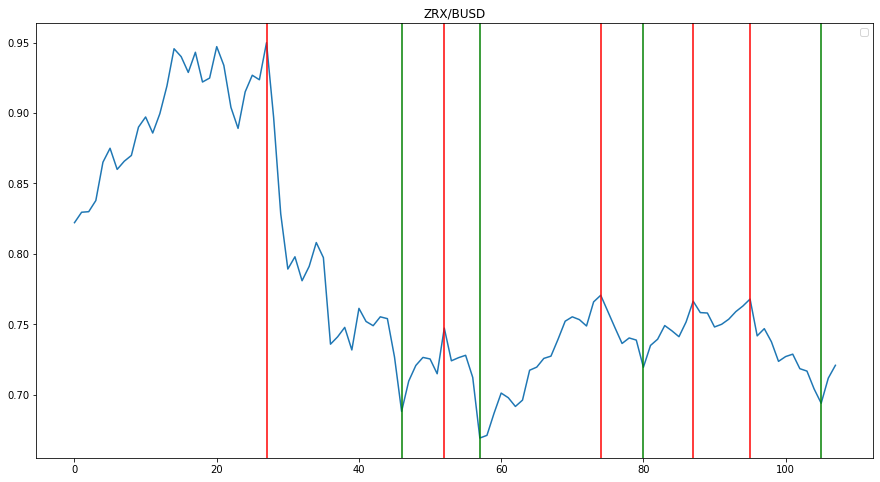

In [15]:
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)

# sell, buy = signal_dates()

for xc in buy:
    plt.axvline(x=xc,color='g')

for xc in sell:
    plt.axvline(x=xc,color='r')

# draw the last call only
# b = buy[-1]
# plt.axvline(x=b,color='g')

# s = sell[-1]
# plt.axvline(x=s,color='r')
plt.title(symbol)
plt.legend()
plt.show()

In [16]:
s=ta.ha(data['Open'],data['High'],data['Low'],data['Close'])
s

,HA_open,HA_high,HA_low,HA_close
0,0.814000,0.841600,0.805800,0.818850
1,0.816425,0.837500,0.816425,0.826375
2,0.821400,0.837500,0.817200,0.828925
3,0.825163,0.848200,0.825163,0.837325
4,0.831244,0.865600,0.831244,0.851825
5,0.841534,0.875000,0.841534,0.863875
6,0.852705,0.876000,0.852705,0.866725
7,0.859715,0.873300,0.845200,0.861875
8,0.860795,0.886000,0.858700,0.869875
9,0.865335,0.904900,0.863800,0.881825


In [17]:
# l = [0,2,3,5,8,7,4,5,2,1,5]

# dff = pd.DataFrame(l[:-2])

# dff